# Probabilistic Programming

## Simple Probabilistic Programming example  

+ Visitors to web site a
    + those that convert
+ Visitors to web site b
    + those that convert


In [23]:
from __future__ import division

import random

%matplotlib inline
import matplotlib.pyplot as plt

import itertools

import numpy as np

In [2]:
def compare_conversion(sim, obs):
    '''Return True if two observations are the same.'''
    return sim == obs

compare_conversion(42, 42), compare_conversion(42, 99)

(True, False)

In [7]:
n_visitors_a = 100
n_conv_a = 4

n_visitors_b = 40
n_conv_b = 2

## Simple Simulation for the number of conversions 

In [8]:
def estimate_conversion(n_visitors, n_conv, trial_conversion, n_estimates=5000):
    '''
    Return n_estimates estimates of the conversion fraction of a layout that 
    received n_visitors, n_conv of which converted.
    '''
    i = 0
    estimates = []
    while i < n_estimates:
        p = trial_conversion()
        n_sim = simulate_conversion(p, n_visitors)
        if n_conv == n_sim:
            estimates.append(p)
            i += 1
    return estimates

In [9]:
def trial_conversion_a():
    '''Return a random number in interval (0, 1).'''
    return random.random()

print trial_conversion_a()

0.0887941376136


In [10]:
def simulate_conversion(p, n_visitors):
    '''Returns number of vistors who convert given conversion fraction p.'''
    outcomes = [random.random() < p  for _ in range(n_visitors)]
    # print p, outcomes
    return sum(outcomes)

simulate_conversion(0.5, 10)

4

In [11]:
a_estimates = estimate_conversion(n_visitors_a, n_conv_a, trial_conversion_a)
len(a_estimates)

5000

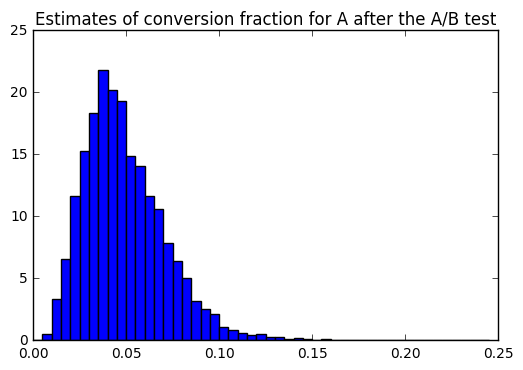

In [12]:
abbins = [i/200.0 for i in range(50)]  # 50 bins between 0 and 0.25

plt.hist(a_estimates, bins=abbins, normed=True)
plt.title('Estimates of conversion fraction for A after the A/B test');

In [13]:
def trial_conversion_b():
    '''Return a random number around 0.06+/-0.02.'''
    while True:
        x = random.normalvariate(mu=0.06, sigma=0.02)
        if 0 <= x <= 1:
            return x

trial_conversion_b()

0.0495875151824475

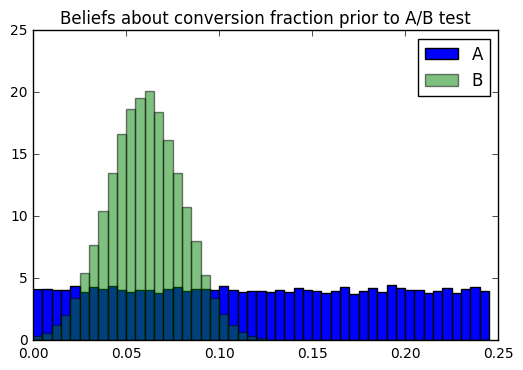

In [14]:
trial_as = [trial_conversion_a() for _ in range(100000)]
trial_bs = [trial_conversion_b() for _ in range(100000)]

plt.hist(trial_as, bins=abbins, label='A', normed=True)
plt.hist(trial_bs, bins=abbins, label='B', alpha=0.5, normed=True)
plt.title('Beliefs about conversion fraction prior to A/B test')
plt.legend();

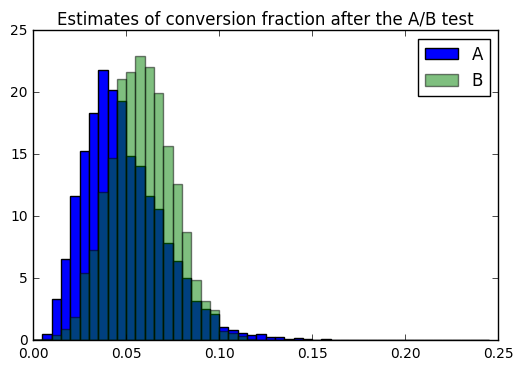

In [15]:
b_estimates = estimate_conversion(n_visitors_b, n_conv_b, trial_conversion_b)
plt.hist(a_estimates, bins=abbins, label='A', normed=True)
plt.hist(b_estimates, bins=abbins, label='B', alpha=0.5, normed=True)
plt.title('Estimates of conversion fraction after the A/B test')
plt.legend();

In [16]:
b_better = [b > a for a, b in zip(a_estimates, b_estimates)]
print(b_better[:10])
print(sum(b_better)/len(b_better))

[False, True, False, True, True, True, True, True, False, False]
0.6642


# Improved Version

In [24]:
def abayes(data, prior_sampler, simulate, compare):
    '''Yield samples from the posterior by Approximate Bayesian Computation.'''
    for p in prior_sampler:
        if compare(simulate(p), data):
            yield p
            
def simulate_conversion(p, n_visitors):
    '''Returns number of vistors who convert given conversion fraction p.'''
    # This used to be "outcomes = [random.random() < p for _ in range(nvisitors)]"
    outcomes = (random.random() < p for _ in range(n_visitors))
    return sum(outcomes)

tests= [simulate_conversion(0.1, 100) for _ in range(10)]
print tests, np.mean(tests)

[10, 11, 11, 10, 11, 4, 9, 13, 12, 12] 10.3


In [26]:
def uniform_prior_sampler():
    '''Yield random numbers in interval (0, 1).'''
    while True:
        yield random.random()
        
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(itertools.islice(iterable, n))

take(3, uniform_prior_sampler())

[0.409212692991092, 0.18931094972725782, 0.461903368051063]

+ Create a generator using function abayes together with specific inputs including a prior and simulate function.
+ Each value will have successfulling matched trial data in simulation.

In [27]:
posterior_a_sampler = abayes( 
    data=n_conv_a,# converters to A
    prior_sampler=uniform_prior_sampler(),
    simulate=lambda p: simulate_conversion(p, n_visitors_a),  #hard codes number of visitors in experiment
    compare=compare_conversion)

take(5, posterior_a_sampler)

[0.025013802557253384,
 0.028195571424752708,
 0.02657794270786573,
 0.04111848898726045,
 0.06367217555851978]

Now setup for experiment b.

In [28]:
# B's prior function
def normal_prior_sampler(mu=0.06, sigma=0.02):
    '''Yield stream of samples from normal distribution in interval (0, 1).'''
    while True:
        x = random.normalvariate(mu, sigma)
        if 0 <= x <= 1:
            yield x

#B's Posterior function using abayes with different prior and simulate_conversion constant parameter.           
posterior_b_sampler = abayes(
    data=n_conv_b,
    prior_sampler=normal_prior_sampler(),
    simulate=lambda p: simulate_conversion(p, n_visitors_b),
    compare=compare_conversion)

take(5, posterior_a_sampler)

[0.08862952688047765,
 0.06049292928058614,
 0.049548957793325576,
 0.08435717866258774,
 0.06251596617577393]

Percentage of cases where b was better:  0.6514


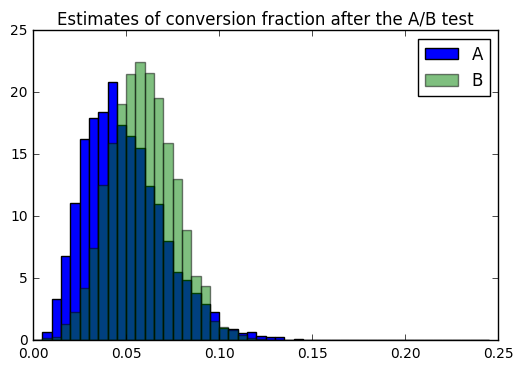

In [32]:
nsamples = 5000
a_samples = take(nsamples, posterior_a_sampler)
b_samples = take(nsamples, posterior_b_sampler)

abbins = [i/200.0 for i in range(50)]  # 50 bins between 0 and 0.25
plt.hist(a_samples, bins=abbins, label='A', normed=True)
plt.hist(b_samples, bins=abbins, label='B', alpha=0.5, normed=True)
plt.title('Estimates of conversion fraction after the A/B test')
plt.legend();

b_better = [b > a for a, b in zip(a_samples, b_samples)]
print "Percentage of cases where b was better: ",sum(b_better)/len(a_samples)

# Online Experiment
## Data arives and is integrated

In [35]:
#conversion data as it arrives
conversions = [1, 0, 2, 0, 1]

In [75]:
def sampler_from_samples(samples):
    '''
    Returns a generator that yields a shuffled repeating 
    sequence of items from the finite iterable samples.
    '''
    samples = list(samples)
    random.sample(samples, len(samples))
    return itertools.cycle(samples)

def online_abayes(datas, prior_sampler, simulate, compare, nsamples=10000):
    '''Yield nsamples from the posterior for each observation in datas.'''
    for data in datas:
        posterior_samples = take(nsamples, abayes(data, prior_sampler, simulate, compare))
        yield posterior_samples
        prior_samples = posterior_samples
        prior_sampler = sampler_from_samples(prior_samples)


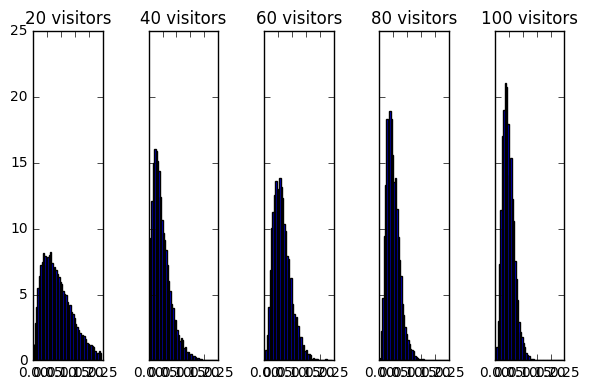

In [77]:
posteriors = online_abayes(
    datas=conversions,
    prior_sampler=uniform_prior_sampler(),
    simulate=lambda p: simulate_conversion(p, 20),
    compare=compare_conversion)

fig, ax = plt.subplots(1, len(conversions), sharey=True)

for i, p in enumerate(posteriors):
    ax[i].hist(p, bins=abbins, normed=True)
    ax[i].set_title('{} visitors'.format((i+1)*20))
fig.tight_layout()

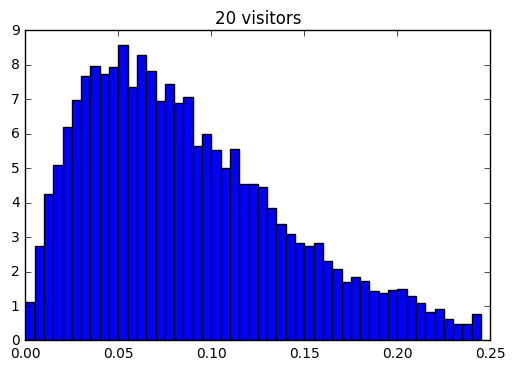

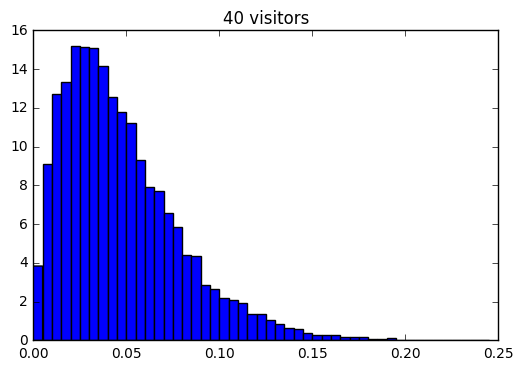

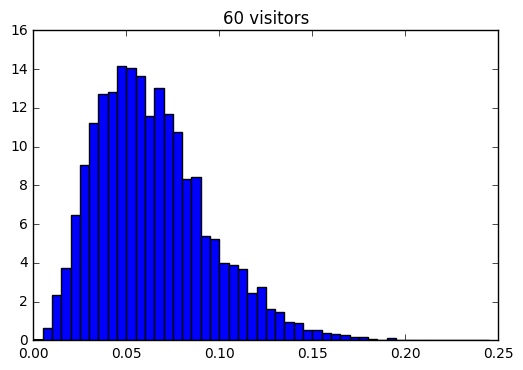

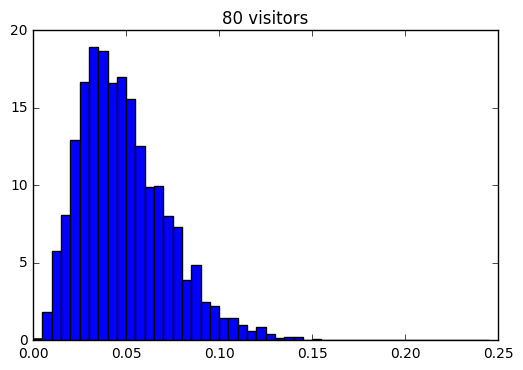

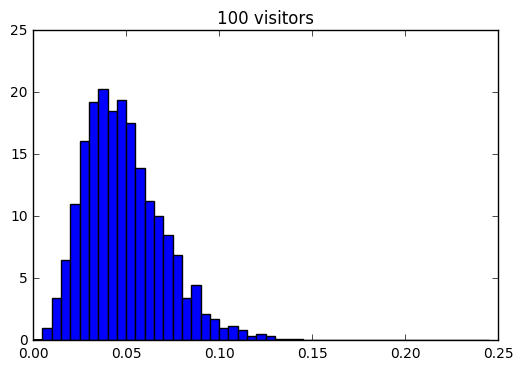

In [80]:
posteriors = online_abayes(
    datas=conversions,
    prior_sampler=uniform_prior_sampler(),
    simulate=lambda p: simulate_conversion(p, 20),
    compare=compare_conversion)

for i, p in enumerate(posteriors):
    plt.hist(p, bins=abbins, normed=True)
    plt.title('{} visitors'.format((i+1)*20))
    plt.show()
